In [1]:
import matplotlib.pyplot as plt
import duckdb

from pathlib import Path
import pandas as pd
from gdrive_fsspec import GoogleDriveFileSystem


cache_dir = Path(".cache")
cache_dir.mkdir(exist_ok=True)

conn = duckdb.connect()

# Real-word dataset

- [Google Drive with real-world data](https://drive.google.com/drive/u/3/folders/1voPQLOcWrLLdxL1gv9rSVn3rWlKz0G_y)


## Columns description

- `#` index (drop)
- `date(ro.created)` - date of report order
- `business_id` - static business id (drop)
- `multi_store_id` - parent store hierarchy
- `store_id` - store id
- `town` - town might have multiple stores
- `county` - static, only one value
- `postcode`
- `product_id` - what does product id of zero mean, unallocated items
- `comment` - i think it's a item name + variant (CHANGE)
- `sku` - should be correlated to product_id? check. need casting to `sku::text` (drop)
- `variation` - always empty (drop)
- `category` - breadcrumb navigation hierarchy (needs cleaning)
- `brand` 630 distinct brands
- `promotion_id` it's a promotion identifier. So we can get basic flag like "the promotion was applied"
- `unit_price` - sometimes 0 - what does it mean. Probaly price was entered manually. There is a concept of "price type"
- `ro.nett_amt/ro.qty`
- `ro.discount_amt/ro.qty`
- `sum(ro.qty)` - fractions - weighted pricing type item


In [2]:
file_name = "Dataset_CA_P&G_230925.csv"  # ~ 330MB
local_path = cache_dir / file_name

if local_path.exists():
    print("✅ Using cached file")
    raw_df = pd.read_csv(local_path)
else:
    print("⬇️ Downloading from Google Drive...")
    # Open "Datasets_230925" folder as file system
    gfs = GoogleDriveFileSystem(
        token="browser", root_file_id="1voPQLOcWrLLdxL1gv9rSVn3rWlKz0G_y"
    )
    with gfs.open(file_name) as fsrc, open(local_path, "wb") as fdst:
        fdst.write(fsrc.read())
    print("💾 Saved to cache")
    raw_df = pd.read_csv(local_path)

raw_df.head()

✅ Using cached file


/var/folders/t9/hk7ywmq13ml9md9rwm0f83dw0000gn/T/ipykernel_28974/1348541769.py:6: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv(local_path)


,#,date(ro.created),business_id,multi_store_id,store_id,town,county,postcode,country_id,add1,...,comment,sku,variation,category,brand,promotion_id,unit_price,ro.nett_amt/ro.qty,ro.discount_amt/ro.qty,sum(ro.qty)
0,1,2025-09-21,163,239,500,SAINT EUSTACHE,QC,J7P 0T4,38,163 25E AVENUE,...,COUPE DE GRIFFES,NaN,NaN,NaN,NaN,0,10.00,10.00,0.0,2.0
1,2,2025-09-21,163,239,500,SAINT EUSTACHE,QC,J7P 0T4,38,163 25E AVENUE,...,COUOPE DE GRIFFES,NaN,NaN,NaN,NaN,0,10.00,10.00,0.0,1.0
2,3,2025-09-20,163,239,500,SAINT EUSTACHE,QC,J7P 0T4,38,163 25E AVENUE,...,COUPE DE GRIFFES,NaN,NaN,NaN,NaN,0,10.00,10.00,0.0,2.0
3,4,2025-09-19,163,239,500,SAINT EUSTACHE,QC,J7P 0T4,38,163 25E AVENUE,...,COUPE DE GRIFFES,NaN,NaN,NaN,NaN,0,10.00,10.00,0.0,1.0
4,5,2025-09-18,163,239,500,SAINT EUSTACHE,QC,J7P 0T4,38,163 25E AVENUE,...,mangechato,NaN,NaN,NaN,NaN,0,3.29,3.29,0.0,1.0


In [3]:
df = raw_df.copy()

# rename columns
df.rename(
    columns={
        "date(ro.created)": "date",
        "town": "store_town",
        "postcode": "store_postcode",
        "product_id": "item_id",
        "sku": "item_sku",
        "comment": "item_comment",
        "category": "item_category_hierarchy",
        "brand": "item_brand",
        "promotion_id": "item_promotion_id",
        "unit_price": "item_unit_price",
        "ro.nett_amt/ro.qty": "item_unit_net_price",
        "ro.discount_amt/ro.qty": "item_discount_amount",
        "sum(ro.qty)": "demand",
    },
    inplace=True,
)

# filtering
# 1. Drop "unallocated items"
df = df[df["item_id"] != 0]  # exclude item_id = 0

# basic transforms
df["store_town"] = df["store_town"].str.upper()
df["store_postcode"] = df["store_postcode"].str.upper()
df["item_brand"] = df["item_brand"].fillna("N/A")
df["item_promo_applied"] = df["item_promotion_id"] != 0
df["item_category"] = df["item_category_hierarchy"].str.split(">").str[-1].str.strip()
df["item_category"] = df["item_category"].fillna("Unallocated")
df["item_category"] = df["item_category"].str.upper()

# column type casting
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.astype({"item_promo_applied": "int"})

# column drops
df.drop(
    columns=[
        "#",
        "business_id",
        "county",
        "country_id",
        "add1",
        "variation",
        "item_promotion_id",
        "item_comment",
        "item_sku",
        "item_category_hierarchy",
    ],
    inplace=True,
)


print("✅ Data loaded:", df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1507901 entries, 33 to 1519127
Data columns (total 13 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   date                  1507901 non-null  datetime64[ns]
 1   multi_store_id        1507901 non-null  int64         
 2   store_id              1507901 non-null  int64         
 3   store_town            1507901 non-null  object        
 4   store_postcode        1507901 non-null  object        
 5   item_id               1507901 non-null  int64         
 6   item_brand            1507901 non-null  object        
 7   item_unit_price       1507901 non-null  float64       
 8   item_unit_net_price   1507522 non-null  float64       
 9   item_discount_amount  1507555 non-null  float64       
 10  demand                1507901 non-null  float64       
 11  item_promo_applied    1507901 non-null  int64         
 12  item_category         1507901 non-null  object

In [4]:
df.head(25)

,date,multi_store_id,store_id,store_town,store_postcode,item_id,item_brand,item_unit_price,item_unit_net_price,item_discount_amount,demand,item_promo_applied,item_category
33,2025-09-13,239,500,SAINT EUSTACHE,J7P 0T4,22602,FAIM MUSEAU,2.99,2.9900,0.0000,1.0,0,NOURRITURE CRUE
34,2025-07-28,239,500,SAINT EUSTACHE,J7P 0T4,22602,FAIM MUSEAU,2.99,2.9900,0.0000,1.0,0,NOURRITURE CRUE
35,2025-08-02,239,500,SAINT EUSTACHE,J7P 0T4,22605,FAIM MUSEAU,38.99,38.9900,0.0000,1.0,0,NOURRITURE CRUE
36,2025-07-14,239,500,SAINT EUSTACHE,J7P 0T4,22605,FAIM MUSEAU,38.99,38.9900,0.0000,3.0,0,NOURRITURE CRUE
37,2025-09-14,239,500,SAINT EUSTACHE,J7P 0T4,22606,FAIM MUSEAU,32.99,32.9900,0.0000,1.0,0,NOURRITURE CRUE
38,2025-08-09,239,500,SAINT EUSTACHE,J7P 0T4,22606,FAIM MUSEAU,32.99,32.9900,0.0000,1.0,0,NOURRITURE CRUE
39,2025-07-24,239,500,SAINT EUSTACHE,J7P 0T4,22606,FAIM MUSEAU,32.99,32.9900,0.0000,1.0,0,NOURRITURE CRUE
40,2025-09-07,239,500,SAINT EUSTACHE,J7P 0T4,22607,FAIM MUSEAU,47.99,47.9900,0.0000,1.0,0,NOURRITURE CRUE
41,2025-07-17,239,500,SAINT EUSTACHE,J7P 0T4,22608,FAIM MUSEAU,38.99,38.9900,0.0000,1.0,0,NOURRITURE CRUE
42,2025-07-07,239,500,SAINT EUSTACHE,J7P 0T4,22609,FAIM MUSEAU,51.99,51.9900,0.0000,1.0,0,NOURRITURE CRUE


## 1. Target sanity & data granularity

The grain is `(date, store_id, item_id)`.

**Conclusions**:

1. Presence of duplicated rows `(data x store_id z item_id)`
2. Presence of negative demand.
3. Presence of negative discounts.
4. Pricing identity (item_unit_price - item_discount_amount ≈ item_unit_net_price) does not match for some stores


In [5]:
# Is the key (data x store_id z item_id) unique?
conn.execute("""
select 
  cast(date as date) as d, store_id, item_id, count(*) as n_rows
from df
group by 1,2,3
having count(*) > 1
""").df()

,d,store_id,item_id,n_rows
0,2025-05-28,277,159584,2
1,2024-09-26,276,24879,2
2,2025-08-26,454,42420,2
3,2025-01-27,440,450478,2
4,2025-09-18,439,28520,2
...,...,...,...,...
741,2025-09-21,473,453095,2
742,2024-12-30,308,28101,2
743,2025-03-31,308,453165,2
744,2025-08-31,288,28520,2


In [6]:
# Lookup particular non-unique key
conn.execute("""
select * from df
where store_id = 341 and item_id = 26064 and date = date('2025-08-28')
""").df()

,date,multi_store_id,store_id,store_town,store_postcode,item_id,item_brand,item_unit_price,item_unit_net_price,item_discount_amount,demand,item_promo_applied,item_category
0,2025-08-28,335,341,SAINT JEROME,J7Y 1S1,26064,BOREAL,2.29,2.136551,0.15,1.0,0,NOURRITURE HUMIDE
1,2025-08-28,335,341,SAINT JEROME,J7Y 1S1,26064,BOREAL,0.00,NaN,NaN,0.0,0,NOURRITURE HUMIDE


In [7]:
# Are there negative or fractional units?
conn.execute("""
select
  sum(case when demand < 0 then 1 else 0 end) as neg_units,
  sum(case when item_discount_amount < 0 then 1 else 0 end) as negative_discount_rows,
  avg((demand != round(demand))::int)::double as frac_non_integer_share
from df
""").df()

,neg_units,negative_discount_rows,frac_non_integer_share
0,55.0,2672.0,0.000011


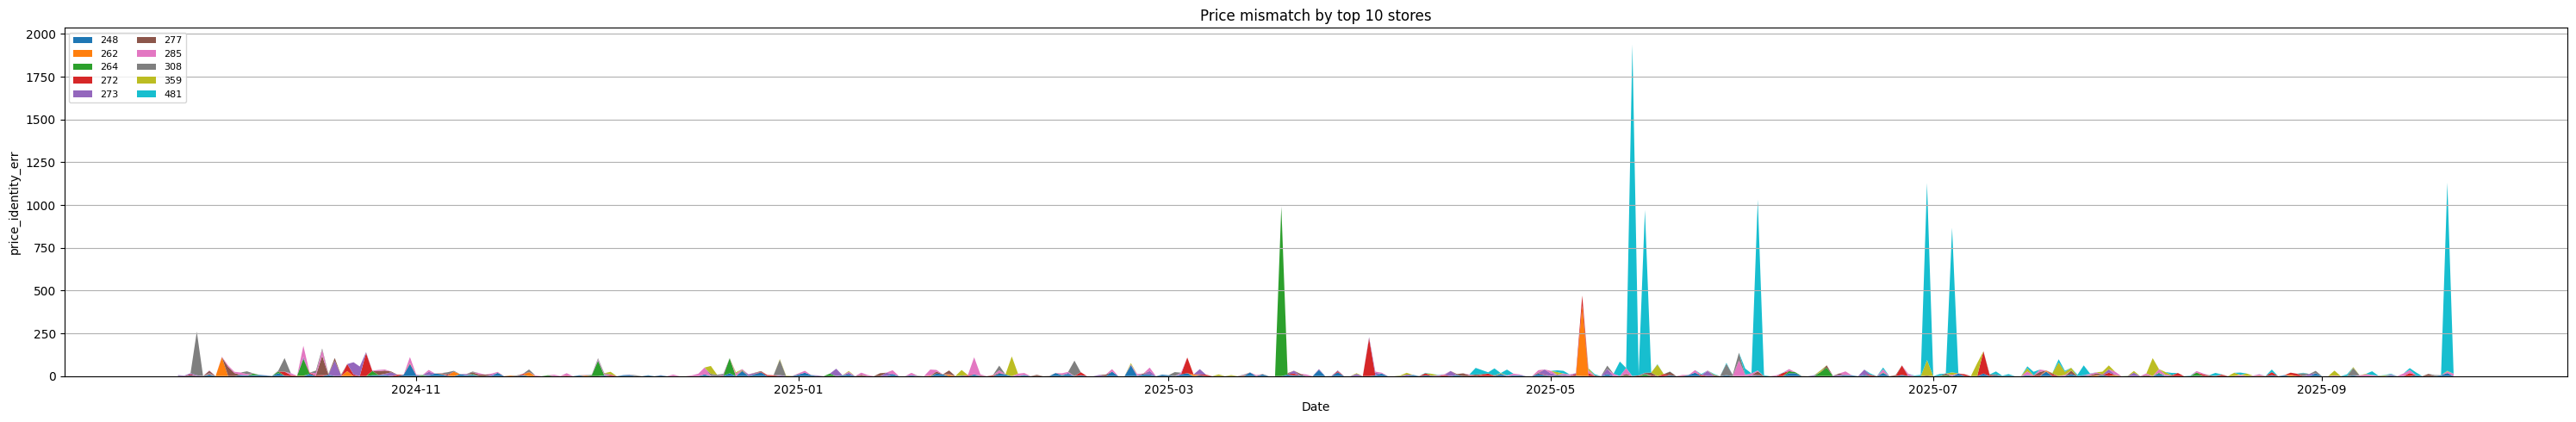

In [8]:
price_err_df = conn.execute("""
select
    date,
    store_id,
    sum(abs(item_unit_price - item_unit_net_price - item_discount_amount)) as price_identity_err
from df
group by 1, 2
""").df()

top_n = 10
top_stores = (
    price_err_df.groupby("store_id")["price_identity_err"]
    .sum()
    .sort_values(ascending=False)
    .head(top_n)
    .index
)

wide = (
    price_err_df[price_err_df["store_id"].isin(top_stores)]
    .pivot_table(
        index="date", columns="store_id", values="price_identity_err", aggfunc="sum"
    )
    .fillna(0)
    .sort_index()
)

fig, ax = plt.subplots(figsize=(30, 5))
ax.stackplot(wide.index, wide.T.values, labels=wide.columns)
ax.set_title(f"Price mismatch by top {top_n} stores")
ax.set_xlabel("Date")
ax.set_ylabel("price_identity_err")
# ax.set_yscale('log')
ax.legend(loc="upper left", ncol=2, fontsize=8)
ax.grid(True, axis="y")
plt.tight_layout()
plt.show()

## 2. Store Coverage

Does all store report data on schedule?


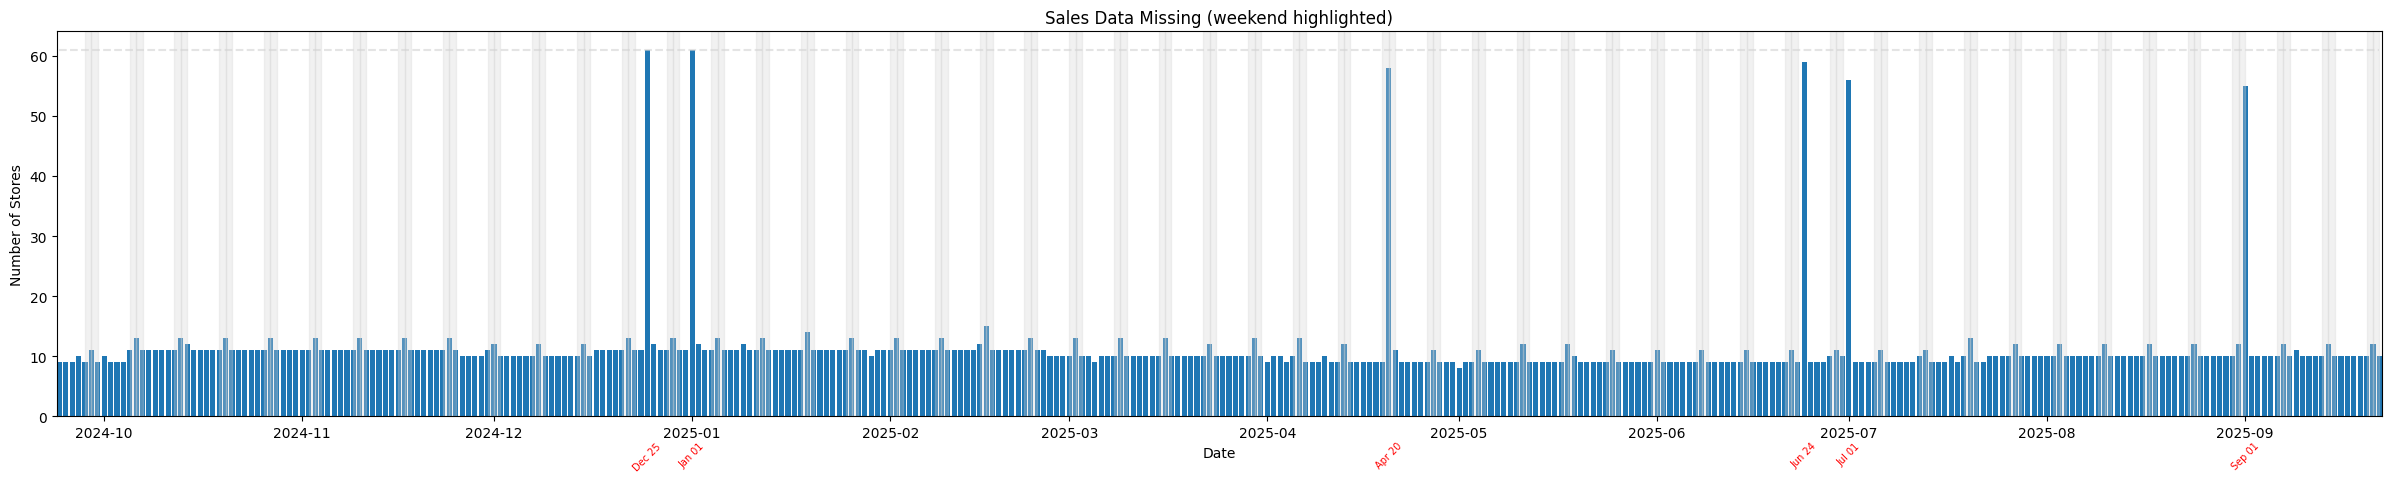

In [9]:
# all available dates
date_spine_df = conn.execute("""
select * 
from generate_series(
    (select min(date) from df),
    (select max(date) from df),
    interval 1 day
) as g(d)
""").df()

# all available stores
store_spine_df = conn.execute("""
select distinct store_id from df
""").df()

# all dates x all stores (cartesian)
full_store_calendar_df = conn.execute("""
select ds.d, ss.store_id
from date_spine_df ds
cross join store_spine_df ss
""").df()

# store activity in certain day
store_days_df = conn.execute("""
select
    date as d,
    store_id,
    1 as has_row
from df
group by 1, 2
""").df()

store_coverage_df = conn.execute("""
select fsc.d, fsc.store_id, coalesce(sd.has_row,0) as has_row
from full_store_calendar_df fsc
left join store_days_df sd using(d, store_id)
""").df()

store_days_summary_df = conn.execute("""
select
  d,
  sum(has_row) as active_stores,
  count(*) - sum(has_row) as missing_store_days
from store_coverage_df
group by 1
order by 1
""").df()

# Ploting
fig, ax = plt.subplots(figsize=(30, 5))
ax.bar(
    store_days_summary_df["d"],
    store_days_summary_df["missing_store_days"],
)
# Highlight weekends
for date in store_days_summary_df["d"]:
    if date.weekday() >= 5:  # 5 = Saturday, 6 = Sunday
        ax.axvspan(date, date + pd.Timedelta(days=1), color="lightgray", alpha=0.3)

# Add horizontal line to mark max stores
ax.hlines(
    y=len(store_spine_df),
    xmin=store_days_summary_df["d"].min(),
    xmax=store_days_summary_df["d"].max(),
    color="lightgray",
    linestyles="dashed",
    alpha=0.6,
)

# Highlight days when missing_store_days exceeds threshold
threshold = 30
above = store_days_summary_df[store_days_summary_df["missing_store_days"] > threshold]

for _, row in above.iterrows():
    ax.text(
        row["d"],
        -4,  # slightly below axis
        row["d"].strftime("%b %d"),
        rotation=45,
        color="red",
        ha="center",
        va="top",
        fontsize=7,
    )

ax.set_title("Sales Data Missing (weekend highlighted)")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Stores")
plt.margins(x=0)
plt.show()

# notice "dead stores" ~ 10

## 3. Item lifecycle


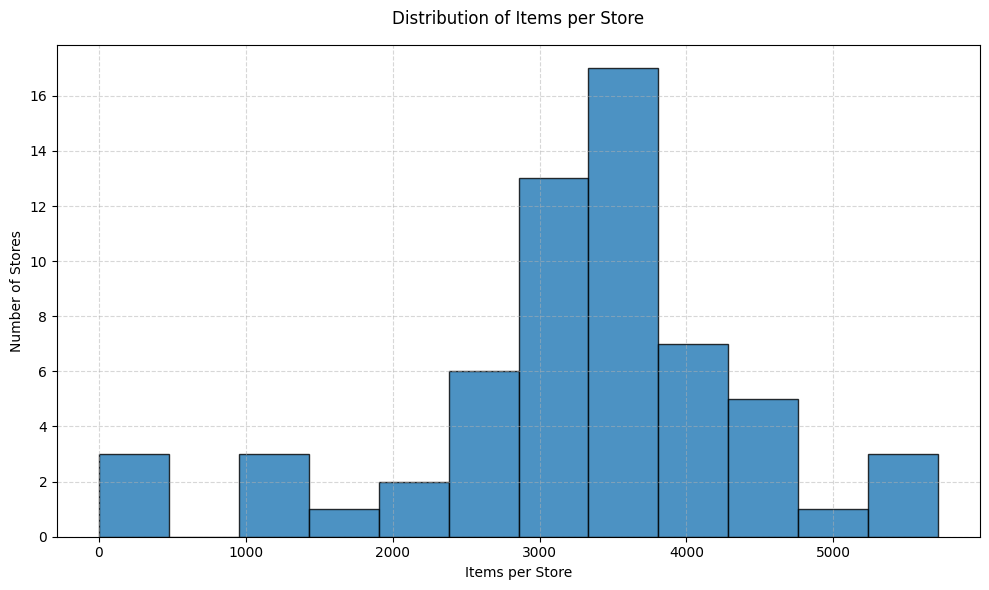

In [10]:
# average number of items per store

per_store_items_df = conn.execute("""
with
  base as (
    select date as d, store_id, item_id
    from df
  ),
  lifecycles as (
    select
      d, store_id, item_id,
      min(d) over (partition by store_id, item_id) as first_seen,
      max(d) over (partition by store_id, item_id) as last_seen
    from base
    group by 1,2,3
  )
  select
    store_id,
    count(distinct item_id) as items_per_store
  from lifecycles
  group by 1
  order by 2 desc
""").df()

# plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(per_store_items_df["items_per_store"], bins=12, edgecolor="black", alpha=0.8)
ax.set_title("Distribution of Items per Store", pad=15)
ax.set_xlabel("Items per Store")
ax.set_ylabel("Number of Stores")
ax.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [11]:
# (a) how long a store–item “exists” in your data and
# (b) how often it shows up during that existence
item_lifespan_df = conn.execute("""
with daily as (
  select
    cast(date as date) as d, store_id, item_id,
    sum(demand) as qty
  from df
  group by 1,2,3
),
lifecycles as (
  select
    store_id,
    item_id,
    min(d) as first_seen,
    max(d) as last_seen,
    count(*) as n_days_with_rows,
    sum(qty) as total_units,
    datediff('day', min(d), max(d)) + 1 as lifespan_days
  from daily
  group by 1,2
)
select
  avg(lifespan_days) as avg_lifespan_days,
  avg(n_days_with_rows) as avg_days_with_rows,
  avg(n_days_with_rows * 1.0 / nullif(lifespan_days,0)) as avg_coverage_ratio,
  avg(total_units) as avg_units_per_listing
from lifecycles
""").df()


item_lifespan_df

,avg_lifespan_days,avg_days_with_rows,avg_coverage_ratio,avg_units_per_listing
0,132.92495,7.574206,0.376809,12.553881


### Date column


In [12]:
%%sql eda_date_df <<

with sales as (
    select
        date,
        sum(sales) as sales
    from df
    group by date
)
select
    d.d as date,
    s.sales as sales
from date_spine_df d
left join sales s on (s.date = d.d)
order by d.d

UsageError: Cell magic `%%sql` not found.


In [ ]:
plt.figure(figsize=(30, 6))

plt.bar(x=eda_date_df["date"], height=eda_date_df["sales"])
plt.xlabel("Date")
plt.ylabel("Items Sold")
plt.title("Sales Over Time (qty)")
plt.margins(x=0)
plt.show()

### Stores

- number of stores, numer of multistores in time
- how many stores each multistore has
- sales per multistore, sales per store


In [ ]:
%%sql eda_stores_df <<

with stores as (
    select
        date,
        count(distinct store_id) as stores,
        count(distinct multi_store_id) as multi_stores
    from df
    group by date
)
select
    d.d as date,
    s.stores as stores,
    s.multi_stores as multi_stores
from date_spine_df d
left join stores s on (s.date = d.d)
order by d.d

In [ ]:
plt.figure(figsize=(30, 6))
plt.plot(eda_stores_df["date"], eda_stores_df["stores"], linewidth=1)
plt.plot(eda_stores_df["date"], eda_stores_df["multi_stores"], linewidth=1)

plt.title("Store Churns (openings, closures, mergers)")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend(["Stores", "Multi-stores"])
plt.grid(True, which="major", linestyle="--", linewidth=0.5, color="gray", alpha=0.4)
plt.tight_layout()
plt.show()


### Items

- how many distinct products were sold in each store


In [ ]:
%%sql
select * from df where sales < 0 limit 100;

In [ ]:
%sql select min(date), max(date), date_diff('day', min(date), max(date)) as date_diff from df

In [ ]:
%sql select count(distinct item_id), count(distinct store_id) from df 

In [ ]:
%sql select category_parsed, count(1) from df group by 1 order by 2 desc

In [ ]:
%sql select * from raw_df where item_sku is null

In [ ]:
%%sql
select distinct(multi_store_id) from raw_df

In [ ]:
products_spine_df = raw_df[["store_id", "item_id"]].dropna().drop_duplicates()


## Questions

1. Sales moze byc ujemne. Domyślam się, ze oryginalne query wzielo to pod uwagę. Wydaje mi się ze lepiej wykluczyć zwroty
2. Sales moze byc ulamkiem? Why
3. Czy `product_id` i `sku` to to samo?
4. Co to `multi_store_id`?
5. Czy `promotion_id == 0` oznacza brak promocji?
6.
